In [1]:
from flask import Flask, render_template, request
import requests
import pandas as pd
import re
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import nltk
from nltk import pos_tag
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

/home/cjdavis/anaconda3/envs/insight/lib/python3.7/site-packages/sqlalchemy/sql/functions.py:68: SAWarning: The GenericFunction 'array_agg' is already registered and is going to be overriden.
  "is going to be overriden.".format(identifier))


In [165]:
def parse_for_word(row, keyword):
    has_keyword = 0
    text = row["Review"]
    #print (text + "\n")
    average_sentiment = 0
    for word in text.split(" "):
        if keyword in word:
            has_keyword = 1
    if (has_keyword > 0):
        sentence_list, average_sentiment = get_sentences_with_word(text, keyword)
    else:
        sentence_list = []
        combined_score = 0
    return has_keyword, sentence_list, average_sentiment

def get_sentences_with_word(text, keyword):
    average_sentiment = 0
    number_of_sentences = 0
    list_of_sentences = []
    #print(text)
    sentences = tokenize.sent_tokenize(text)
    for sentence in sentences:
        #print (sentence)
        if keyword in sentence:
            list_of_sentences.append(sentence)
            number_of_sentences = number_of_sentences + 1
            sentiment = get_sentiment(sentence)
            #print(sentence, sentiment)
    average_sentiment = float(sentiment / number_of_sentences)
    return list_of_sentences, average_sentiment

def get_sentiment(text):
    sentiment = SentimentIntensityAnalyzer() #### calling Intensity Analyzer
    compound = sentiment.polarity_scores(text)['compound']  ### calling the 'compound' score for the "text" entered
    #if compound > 0:
    #    return 1  ## positive
    #else:
    #    return 0 ## negative
    #else:
        #return "Neutral"     
    #print(compound)
    return compound

In [98]:
f=open("db.txt", "r")
contents=0
if not(contents):
    contents = f.read()
username = contents.split("\n")[0]
password = contents.split("\n")[1]
dbname_photos = 'photos_db'
dbname_reviews = "reviews_db"

In [194]:
con = psycopg2.connect(database = dbname_reviews, user = username, password = password, port=5432, host= "/var/run/postgresql/")
sql_query_reviews = """
SELECT * FROM reviews_data_table;
"""
reviews_data_from_sql = pd.read_sql_query(sql_query_reviews,con)
con.close()

In [190]:
keyword = "parking"

In [195]:
reviews_data_from_sql = reviews_data_from_sql.drop(axis = 1, columns=["index"])
print(reviews_data_from_sql.shape)
print(reviews_data_from_sql.drop_duplicates().shape)
reviews_data_from_sql = reviews_data_from_sql.drop_duplicates()

(17427, 3)
(16111, 3)


In [196]:
%%time
reviews_data_from_sql["has_keyword"], reviews_data_from_sql["sentence_list"], reviews_data_from_sql["average_sentiment_sentence"] = zip(*reviews_data_from_sql.apply(parse_for_word, keyword = keyword, axis=1))

CPU times: user 3.72 s, sys: 469 ms, total: 4.19 s
Wall time: 4.25 s


In [197]:
reviews_data_from_sql.head()

,Review,Title,sentiment_vader,has_keyword,sentence_list,average_sentiment_sentence
0,Love this salon! I was referred over by two of...,Urban Betty,0.9746,0,[],0.0
1,Came in for a summer haircut since my hair was...,Urban Betty,0.9560,0,[],0.0
2,I recently moved and have been looking for a g...,Urban Betty,-0.9035,0,[],0.0
3,Y'all stop what you are doing right now and go...,Urban Betty,0.9911,0,[],0.0
4,"Love, love, love this place! I saw Holly and s...",Urban Betty,0.9844,0,[],0.0


In [198]:
# remove rows where the keyword doesn't occur
reviews_data_from_sql = reviews_data_from_sql[reviews_data_from_sql.has_keyword != 0]
reviews_data_from_sql.head()
reviews_data_from_sql.iloc[0][5]

0.0

In [201]:
d = {'has_keyword':'has_keyword_sum', 'average_sentiment_sentence':'average_sentiment_sentence_average',
     'sentiment_vader':'sentiment_vader_average', 'sentence_list':'sentence_list_combined',
     'Review': 'Review_sum'}
sorted_mean_by_Title=reviews_data_from_sql.groupby('Title').agg({'has_keyword':'sum',
                                                                'average_sentiment_sentence':'mean',
                                                                'sentiment_vader':'mean',
                                                                'sentence_list':'sum',
                                                                'Review':'sum'}).rename(columns=d)
sorted_mean_by_Title.sort_values(by=['has_keyword_sum'], ascending=False, inplace=True)
sorted_mean_by_Title.head(5)

,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum
Title,,,,,
Red Stella Hair Salon,16,0.455166,0.973469,"[The car entrance and parking is underground.,...",I met with Sarah C who is a friend of a friend...
Jose Luis Salon & Boutique,16,0.454506,0.940750,[I never had an issue finding a parking spot i...,Surprised I have not written a review since I ...
WaterStone Salon,12,0.586767,0.939058,"[Easy parking too., They offer free covered pa...",This salon is a great facility with fantastic ...
Frenchy’s Beauty Parlor,12,-0.000896,0.782808,[I would highly recommend a trip to Frenchy's ...,An overdue review for Sandy! As an Austin newb...
Urban Betty,11,0.295627,0.954182,"[When I arrived, parking was convenient as was...",Just finished up with my appointment with Tara...


In [202]:
def scaled_combined_score(row):
    # get the values
    sentiment_score = float(row["average_sentiment_sentence_average"])
    has_keyword_sum = int(row["has_keyword_sum"])
    sentiment_vader = float(row["sentiment_vader_average"])
    # update the sentiment value
    return (combined_function(has_keyword_sum, sentiment_score, sentiment_vader))

def combined_function(has_keyword_sum, sentiment_score, sentiment_vader):
    weight = 0
    if (has_keyword_sum >= 3):
        weight = 0.7
    else:
        alpha = -0.07777
        beta = 0.46666
        weight = alpha * has_keyword_sum * has_keyword_sum + beta * has_keyword_sum
        #print(weight)
    #print(weight, sentiment_score, sentiment_vader)
    return weight * sentiment_score + 0.3 * sentiment_vader

In [209]:
sorted_mean_by_Title['final_score'] = sorted_mean_by_Title.apply(scaled_combined_score, axis=1)
sorted_review_data = sorted_mean_by_Title.sort_values(by=['final_score'], ascending=False)
sorted_review_data.head(5)

,has_keyword_sum,average_sentiment_sentence_average,sentiment_vader_average,sentence_list_combined,Review_sum,final_score
Title,,,,,,
Thomas Saverio Salon,2,0.85855,0.988300,"[Another Kerastase salon, Thomas Serverio is v...","My beautiful and talented hair wizard, Jessica...",0.830714
Urban Hair,4,0.75155,0.984325,[Every stylist is friendly and the location ha...,I love everything about this salon. It's super...,0.821382
The Rusty Shears,2,0.82470,0.936850,"[Plenty of parking, relaxing environment, Very...",Justin was very personable and professional. H...,0.794216
Zig Zag Salon,2,0.77810,0.990150,[Zig Zag caught my attention because it was cl...,I've been going to the same hair stylist in Ho...,0.781210
L7 Salon,6,0.68640,0.986517,"[And best of all, you won't have to empty your...",Jillian does an incredible job with blonde hig...,0.776435


In [212]:
sorted_review_data.iloc[0][4]

"My beautiful and talented hair wizard, Jessica Taylor (formerly of Saks Salon and Jose Luis) has just moved to Thomas Saverio at Parkcrest, and I was her first client! I would follow Jessica to the ends of the earth to keep my hair gorgeous and healthy. Another Kerastase salon, Thomas Serverio is very convenient, easy parking, and the shampoo bowls are the best! You get to LIE DOWN and your neck is supported by your head. So much more comfortable than anywhere else. Jessic is magic with blondes, and my Barbie locks are testament to her expertise! She's also a sweetheart, and I so enjoy our time together! xoxI wanted to wait to make sure my second hair cut was as good as the first and if anything it was even better! Ever since I moved to Austin I felt like no one was cutting my hair as well as in New York even though I was paying the same amount of money which was super frustrating. At my first appointment, Ruben took the time to talk to me about what I was unhappy with and what I real

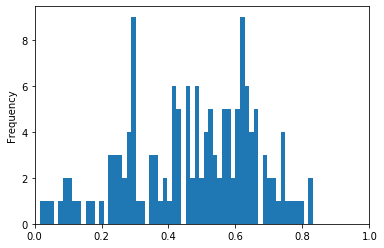

In [204]:
sorted_mean_by_Title.final_score.plot.hist(bins = 100, xlim=[0, 1])